In [1]:
import os
import pandas as pd
import numpy as np

#os.chdir('RUNS/HumanProteome/word2vec_model')
os.system('pwd')

0

In [2]:
# token embeddings
tokens_df = pd.read_csv('../RUNS/HumanProteome/word2vec_model/token_embeddings.csv')

# hotspots
hotspots = pd.read_csv('data/regions_ext_substr.csv')

In [3]:
# extract relevant tokens from big token df
def find_tokens(region, df):
    # tokens in current peptide in hotspot tbl
    tokens = region.split(' ')
    
    # all token embeddings df
    df = df[df['subword'].isin(tokens)].iloc[:,0:100]
    
    return df

# average token embeddings
def sequence_repres(token_emb):
    token_emb = np.array(token_emb, dtype = 'float64')
    
    repres = np.mean(token_emb, axis = 0)
    
    return token_emb, repres

# get labels
def get_labels(df):
    labels_word = df['label']
    labels_word = np.array(labels_word, dtype = 'object')
    
    labels_binary = np.where(labels_word == 'hotspot', 1, 0)
    
    return labels_binary

In [4]:
# choose subset of hotspot table
rnd = np.random.randint(0,hotspots.shape[0], 5000)

hotspots_sub = hotspots.iloc[rnd]
labels_sub = get_labels(hotspots_sub)

In [5]:
sequences = []

for idx, row in hotspots_sub.iterrows():
    
    cnt_tokens = find_tokens(row['tokens'], tokens_df)
    cnt_tokenEmb, cnt_sequence = sequence_repres(cnt_tokens)
    
    sequences.append(cnt_sequence)


In [18]:
# build model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import keras.backend.tensorflow_backend as K
K.set_session

convKernels = 3
windowSize = 3
dilationRate = 1

def residual_blocks(input_conv, dim = 100):
    
    norm1 = layers.BatchNormalization(trainable = True)(input_conv)
    relu1 = layers.Dense(dim, activation = 'relu')(norm1)
    
    convRB_1 = layers.Conv1D(filters = 100,
                           kernel_size = convKernels,
                             strides = 1,
                             padding = 'valid',
                             dilation_rate = dilationRate)(relu1)
    
    norm2 = layers.BatchNormalization(trainable = True)(convRB_1)
    relu2 = layers.Dense(dim, activation = 'relu')(norm2)
    
    convRB_2 = layers.Conv1D(filters = 100,
                           kernel_size = convKernels,
                             strides = 1,
                             padding = 'valid',
                             dilation_rate = dilationRate)(relu2)
    
    return convRB_2
    

def build_and_compile_model():
    # layers
    input_l = keras.Input(shape = (100,), name = 'input_layer')
    
    conv_1 = layers.Conv1D(filters = 100,
                           kernel_size = convKernels,
                           strides = 1,
                           padding = 'valid',
                           dilation_rate = dilationRate)
    
    # here skip-connection layer
    
    RB1 = residual_blocks(conv_1)
    RB2 = residual_blocks(RB1)
    RB3 = residual_blocks(RB2)
    RB4 = residual_blocks(RB3)
    
    # here other convolutional layer
    
    # skip-connection ends here
    
    # 
    conv_final = layers.Conv1D(filters = 4,
                               kernel_size = convKernels,
                               strides = 1,
                               padding = 'valid',
                               dilation_rate = dilationRate)(...)
    
    output = layers.Dense(1, activation = 'sigmoid')(conv_final)
    
    # model
    model = keras.Model(inputs=input_l, outputs=output)
    opt = keras.optimizers.Adagrad()
    
    model.compile(loss=keras.losses.BinaryCrossentropy(),
                    optimizer = opt,
                    metrics=['accuracy'])
    
    return model

In [19]:
model = build_and_compile_model()
model.summary()

ValueError: ('Input has undefined rank:', TensorShape(None))

In [11]:
from sklearn.model_selection import train_test_split

# re-structure data set
sequences = np.array(sequences, dtype = 'float64')
sequences.shape

# split data into training and validation
seq_train, seq_test, Y_train, Y_test = train_test_split(sequences, labels_sub, test_size = .2)


In [12]:
# fit model

history = model.fit(seq_train, Y_train,
                   epochs = 50,
                   verbose = 1,
                   validation_data = [seq_test, Y_test])

Train on 4000 samples, validate on 1000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
4000/4000 [==============================] - 0s 123us/sample - loss: 0.7083 - acc: 0.5337 - val_loss: 1.0202 - val_acc: 0.5060
Epoch 2/50
4000/4000 [==============================] - 0s 61us/sample - loss: 0.6658 - acc: 0.5655 - val_loss: 0.7745 - val_acc: 0.5470
Epoch 3/50
4000/4000 [==============================] - 0s 63us/sample - loss: 0.6551 - acc: 0.5857 - val_loss: 0.6724 - val_acc: 0.5630
Epoch 4/50
4000/4000 [==============================] - 0s 64us/sample - loss: 0.6501 - acc: 0.5907 - val_loss: 0.6655 - val_acc: 0.5750
Epoch 5/50
4000/4000 [==============================] - 0s 62us/sample - loss: 0.6443 - acc: 0.5950 - val_loss: 0.6890 - val_acc: 0.5560
Epoch 6/50
4000/4000 [==============================] - 0s 61us/sample - loss: 0.6356 - acc: 0.6028 - val_loss: 0.6971 - val_acc: 0.5720
Epoch 7/50
4000/4000 [==============================] - 0s 60us/sample - loss: 0.

In [13]:
# run prediction and evaluate
# choose subset of hotspot table
rnd = np.random.randint(0,hotspots.shape[0], 150)

hotspots_pred = hotspots.iloc[rnd]
labels_pred = get_labels(hotspots_pred)

sequences_pred = []

for idx, row in hotspots_pred.iterrows():
    
    cnt_tokens = find_tokens(row['tokens'], tokens_df)
    cnt_tokenEmb, cnt_sequence = sequence_repres(cnt_tokens)
    
    sequences_pred.append(cnt_sequence)

sequences_pred = np.array(sequences_pred, dtype = 'float64')


In [14]:
from sklearn import metrics

# prediction
label_probs = model.predict(sequences_pred, verbose = 2)
#print(label_probs)
label_probs = np.array(np.round(label_probs, decimals = 0), dtype = 'int64')

#print(label_probs)

# evaluate
precision = metrics.precision_score(labels_pred, label_probs)
recall = metrics.recall_score(labels_pred, label_probs)
F1 = metrics.f1_score(labels_pred, label_probs)

print('precision: {} - recall: {} - F1: {}'.format(precision, recall, F1))

matrix = metrics.confusion_matrix(labels_pred, label_probs)
print(matrix)

# classification report
nm = ['non-hotspot','hotspot']
cl = metrics.classification_report(labels_pred, label_probs, target_names = nm)
print(cl)


 - 0s
precision: 0.44047619047619047 - recall: 0.6607142857142857 - F1: 0.5285714285714285
[[47 47]
 [19 37]]
              precision    recall  f1-score   support

 non-hotspot       0.71      0.50      0.59        94
     hotspot       0.44      0.66      0.53        56

    accuracy                           0.56       150
   macro avg       0.58      0.58      0.56       150
weighted avg       0.61      0.56      0.57       150



In [17]:
import shap

background = sequences_pred
explainer = shap.DeepExplainer(model, background)

shap_values = explainer.shap_values(background[:15])


In [18]:
shap.initjs()

shap.force_plot(explainer.expected_value[0],
               shap_values[0][0],
               sequences_pred[0])


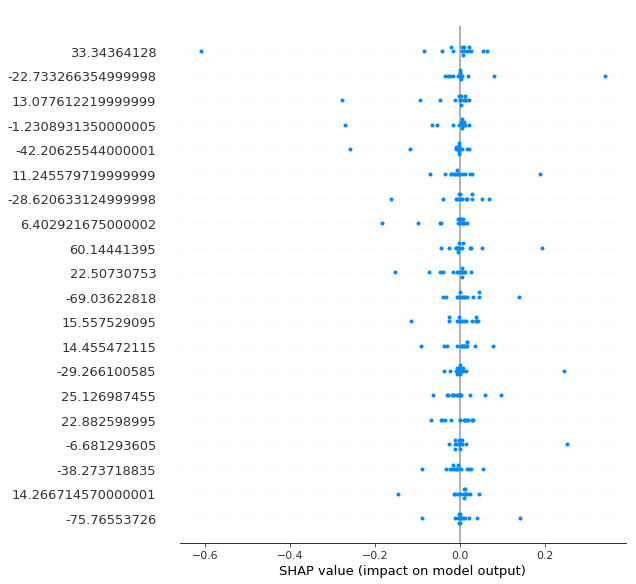

In [19]:
shap.initjs()
shap.summary_plot(shap_values[0], sequences_pred[0])